<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка датасета

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
display(data.shape)
display(data.head())

(159292, 2)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


В исходном датасете 159292 записей. Возьмем только небольшую часть, иначе может не хватить ресурсов:

In [3]:
RND_SEED = 42
TRAIN_SIZE = 5000 # большой набор может уронить тетрадку и студию даже на локальной машине 

In [4]:
data = train_test_split(data, train_size=TRAIN_SIZE, random_state=RND_SEED)[0]

### Загрузка модели
Используем готовую модель *unitary/toxic-bert* 

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = transformers.AutoModel.from_pretrained("unitary/toxic-bert")

### Стемминг
Чтобы сэкономить время и ресурсы еще ограничим длину вектора 80-м процентилем длин полученных векторов.

80-percentile max_len: 128


(5000, 128)

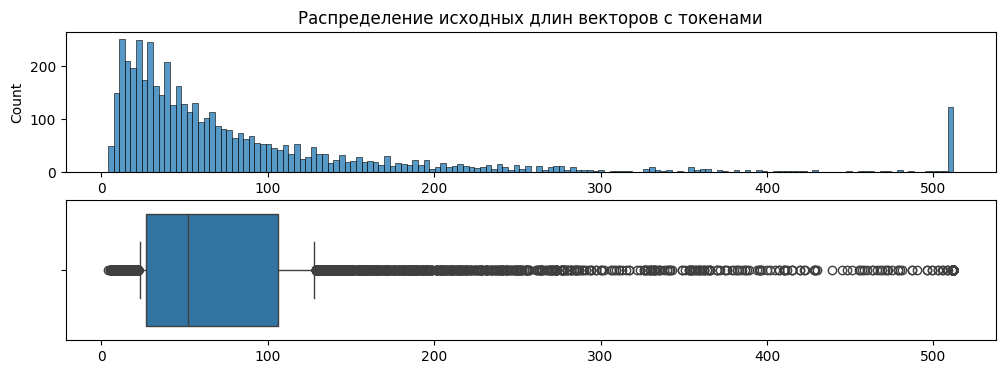

In [6]:
def tokenize(data):
	tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

	len_list = []
	for i in tokenized.values:
		len_list.append(len(i))

	max_len = int(np.percentile(len_list, q=80))
	print(f'80-percentile max_len: {max_len}')

	fig, axes = plt.subplots(2, 1)
	fig.set_size_inches(12, 4)
	sns.histplot(data=len_list, bins=150, ax=axes[0]);
	sns.boxplot(data=len_list, whis=[20, 80], ax=axes[1], orient='h');
	axes[0].set_title('Распределение исходных длин векторов с токенами')
	axes[0].sharex(axes[1])

	padded = np.array([i[:max_len] + [0] * max(0, (max_len - len(i))) for i in tokenized.values])
	attention_mask = np.where(padded != 0, 1, 0)

	return padded, attention_mask

padded, attention_mask = tokenize(data)
padded.shape

- Идея такого ограничения по max_len в том, что, как видно на графиках, основная часть текстов в данном корпусе выдают кол-во лемм заметно меньше максимального кол-ва, поддерживаемого моделью (512), поэтому, если мы будем формировать матрицу на 512 лемм, в ней будет много бесполезных нулей, что неразумно, т.к. обработка лемм BERT-ом - процесс ресурсоемкий.

Можно еще так получить токены, но возвращаемый BatchEncoding еще надо преобразовать в 2d ndarray, плюс большие набор данных и max_length роняют тетрадку и студию:

padded = tokenizer(data['text'].to_list(), padding=True, truncation=True, max_length=128)

## Обучение

### Embeddings

In [7]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
	batch = torch.LongTensor(padded[batch_size * i : batch_size * (i + 1)])
	attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1)])
	with torch.no_grad():
		batch_embeddings = model(batch, attention_mask=attention_mask_batch)
	embeddings.append(batch_embeddings[0][:, 0, :].numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

### Регрессия

In [8]:
features = np.concatenate(embeddings)

X_train, X_test, y_train, y_test = train_test_split(
    features, data['toxic'], test_size=0.2, random_state=RND_SEED)
estimator = LogisticRegression(random_state=RND_SEED).fit(X_train, y_train)
scores = cross_val_score(estimator, X_train, y_train, scoring='f1')
print(f'F1 на кроссвалидации: {scores}')

F1 на кроссвалидации: [0.91156463 0.91780822 0.88111888 0.90540541 0.90789474]


### F1 на тестовой выборке

F1 on test set: 0.95


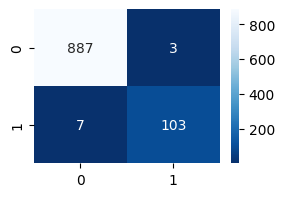

In [9]:
y_pred = estimator.predict(X_test)
print(f'F1 on test set: {f1_score(y_test, y_pred):.02f}')
precision_recall_fscore_support(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues_r');

## Выводы

- Получили датасет toxic_comments
- Чтобы хватило ресурсов, взяли небольшую случайную часть сета в работу (5000 текстов)
- Использовали готовую модель unitary/toxic-bert
- Длину векторов лемм ограничили 80%-ным процентилем длин (~128 лемм)
- Обучили модель логистической регрессии, получили метрику F1 на тестовой выборке, удовлетворяющую условию задачи.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны